<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="800">

# Домашнее задание 5: АБ-тест
</center>

**ФИО:**

## Общая информация

__Дата выдачи:__ 07.04.2025

__Дедлайн:__ 23:59MSK 20.04.2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

На семинаре мы попытались разобраться как устроена процедура АБ-тестирования. В этом задании мы попытаемся закрепить полученные знания и более аккуратно структурировать их.

### Кратко повторим теорию

Мы хотим выктить новую функциональность на сайте. Перед раскаткой нам хочется проверить, какой эффект мы оказываем на пользователя. Выделим две выборки: тестовую (treatment) и контрольную (control). Тестовой покажем новый сайт. Контрольной старый. Замерим инетерсующую нас метрику, нааример, время проведенной на сайте, в обеих группах:

$$
\begin{aligned}
&X^c_1, \ldots, X^c_{n_c} \sim iid (\mu_c, \sigma^2_c) \\
&X^t_1, \ldots, X^t_{n_t} \sim iid (\mu_t, \sigma^2_t)
\end{aligned}
$$

У выборок есть какие-то математические ожидания, дисперсии. Выборки собраны независимо друг от друга. Если их математические ожидания одинаковые, будем считать, что новая функциональность никак не повлияла на пользователей. Сформулируем это в виде нашей нулевой гипотезы:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_c = \mu_t \\
&H_1: \hspace{2mm} \mu_c < \mu_t.
\end{aligned}
$$

Посчитаем по выборке расстояние между математическими ожиданиями $\hat \mu_t - \hat \mu_c$. Оно по ЦПТ имеет нормальное распределение с оценкой дисперсии $\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}$. Получается, что

$$
z = \frac{\hat \mu_t - \hat \mu_c}{\sqrt{\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}}} \sim N(0,1),
$$

при верности нулевой гипотезы и $n \to \infty$. Если это расстояние оказывается слишком большим, мы отказываемся верить в нулевую гипотезу. Эффект от новой функциональности есть. Будем сравнивать наблюдаемое значение $z$ с $z_{1 - \alpha},$ где уровень значимости $\alpha$ выберем до начала эксперимента.

- Если $z < z_{1 - \alpha},$ нулевая гипотеза не отвергается (похоже, что верна). Расстояние маленькое, разницы нет.
- Если $z > z_{1 - \alpha},$ выбираем альтернативу. У на есть значимый эффект на метрику, от веры в нулевую гипотезу придётся отказаться.

> Ничего не понятно? Тогда вам в лекции. Ниже подборка:  

- [Наша лекция про АБ]( )
- [Неделя про проверку гипотез с курсеры](https://www.youtube.com/watch?v=Zv-5gbJtofk&list=PLCf-cQCe1FRxTgNPwcRSkBjvtE8DEm7rU)


## Задания


__а) [1 балл]__ Реализуйте функцию для проверки гипотезы о равенстве математических ожиданий. Она должна принимать на вход две выборки и выдавать на выход наблюдаемое значение статистики `z_obs` и `p_value` для ситуаций с разными альтернативными гипотезами.

In [2]:
def asy_mean_test(x_control, x_treatment, alternative = 'larger'):
    n_c = len(x_control)
    n_t = len(x_treatment)
    mu_c = np.mean(x_control)
    mu_t = np.mean(x_treatment)

    var_c = np.var(x_control, ddof=1)
    var_t = np.var(x_treatment, ddof=1)
    se = np.sqrt(var_c / n_c + var_t / n_t)
    z_obs = (mu_t - mu_c) / se

    if alternative == 'larger':
        p_value = 1 - stats.norm.cdf(z_obs)
    elif alternative == 'smaller':
        p_value = stats.norm.cdf(z_obs)
    elif alternative == 'two-sided':
        p_value = 2 * min(stats.norm.cdf(z_obs), 1 - stats.norm.cdf(z_obs))
    return z_obs, p_value

Если вы написали весь код выше корректно, то строки ниже сработают без проблем.

In [3]:
def gen_sample(n_obs, effect, p_control):
    p_treatment = p_control * (1 + effect)
    x_control = stats.bernoulli(p_control).rvs(n_obs)
    x_treatment = stats.bernoulli(p_treatment).rvs(n_obs)
    return x_control, x_treatment

In [4]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0, 0.2))
assert pval > 0.01

In [5]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0.1, 0.2))
assert pval < 0.01

Для простоты мы дальше будем работать с односторонней альтернативой и тестом для долей.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_t = p_c \\
&H_1: \hspace{2mm} p_t > p_c
\end{aligned}
$$

__б) [2 балла]__ Предположим, что нулевая гипотеза верна. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы.

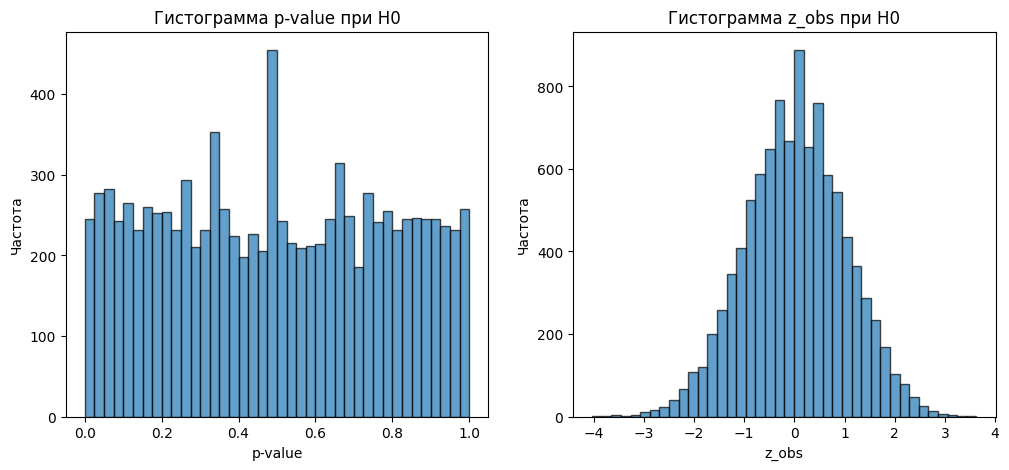

In [6]:
n_sim = 10**4
sample_size = 1000

pvals_null = []
zvals_null = []

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, 0, 0.2)
    z_obs, p_val = asy_mean_test(x_control, x_treatment, alternative='larger')
    pvals_null.append(p_val)
    zvals_null.append(z_obs)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(pvals_null, bins=40, edgecolor='k', alpha=0.7)
plt.title("Гистограмма p-value при H0")
plt.xlabel("p-value")
plt.ylabel("Частота")

plt.subplot(1,2,2)
plt.hist(zvals_null, bins=40, edgecolor='k', alpha=0.7)
plt.title("Гистограмма z_obs при H0")
plt.xlabel("z_obs")
plt.ylabel("Частота")
plt.show()

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__ При верности H0 распределение p-value должно быть равномерным на [0, 1]. Распределение z_obs должно быть приближено к N(0,1), то есть его математическое ожидание ~0.

__в) [1 балл]__ Предположим, что верна альтернативная гипотеза. Доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы и прокомментируйте получившиеся результаты.

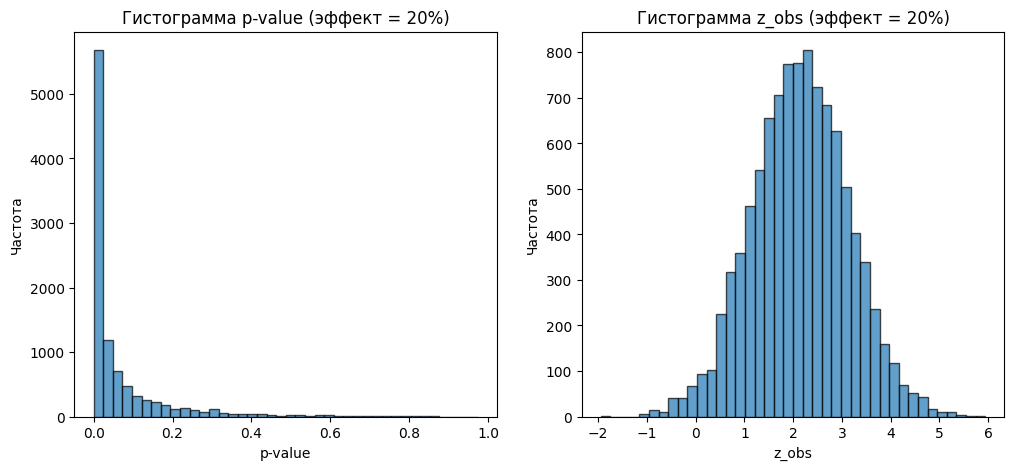

In [7]:
pvals_alt20 = []
zvals_alt20 = []

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, 0.2, 0.2)
    z_obs, p_val = asy_mean_test(x_control, x_treatment, alternative='larger')
    pvals_alt20.append(p_val)
    zvals_alt20.append(z_obs)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(pvals_alt20, bins=40, edgecolor='k', alpha=0.7)
plt.title("Гистограмма p-value (эффект = 20%)")
plt.xlabel("p-value")
plt.ylabel("Частота")

plt.subplot(1,2,2)
plt.hist(zvals_alt20, bins=40, edgecolor='k', alpha=0.7)
plt.title("Гистограмма z_obs (эффект = 20%)")
plt.xlabel("z_obs")
plt.ylabel("Частота")
plt.show()


А как будут выглядеть результаты, если доля в тестовой выборке больше на $40\%$? Проведите симуляции.

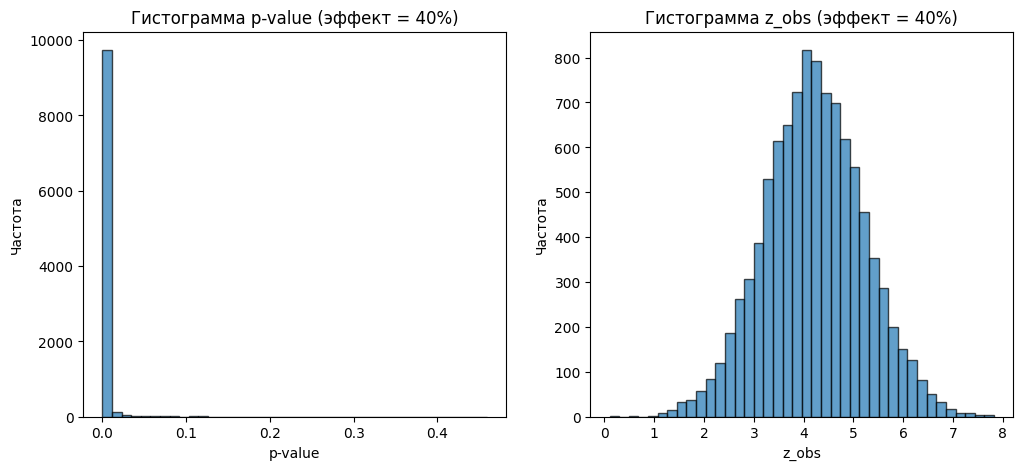

In [8]:
pvals_alt40 = []
zvals_alt40 = []

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, 0.4, 0.2)
    z_obs, p_val = asy_mean_test(x_control, x_treatment, alternative='larger')
    pvals_alt40.append(p_val)
    zvals_alt40.append(z_obs)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(pvals_alt40, bins=40, edgecolor='k', alpha=0.7)
plt.title("Гистограмма p-value (эффект = 40%)")
plt.xlabel("p-value")
plt.ylabel("Частота")

plt.subplot(1,2,2)
plt.hist(zvals_alt40, bins=40, edgecolor='k', alpha=0.7)
plt.title("Гистограмма z_obs (эффект = 40%)")
plt.xlabel("z_obs")
plt.ylabel("Частота")
plt.show()

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__ При верности альтернативной гипотезы распределение p-value смещено влево (множество p-value ≈ 0), а распределение z_obs имеет положительное смещение (математическое ожидание > 0). При увеличении эффекта (40% по сравнению с 20%) смещение становится сильнее, что говорит о более высокой мощности теста.

__г) [1 балл]__ Обычно, перед началом эксперимента, мы фиксируем ошибку первого рода, вероятность отвергнуть нулевую гипотезу, когда она на самом деле верна,  

$$\alpha = \mathbb{P}(H_A \text{ выбрана} \mid H_0 \text{ верна}).$$

Дальше мы принимаем решение, о том, какую гипотезу выбрать, сравнивая `z_obs` с $z_{1 - \alpha},$ либо `pvalue` с $\alpha$ (напомню что мы делаем симуляции для правосторонней альтернативы, поэтому $\alpha$ не надо делить на два).

Давайте проверим для конкретного $\alpha$, что это правда работает. Выберите любое разумное значение $\alpha$. С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$ при верности нулевой гипотезы. Проверьте эти гипотезы и оцените получившееся значение $\alpha$. Правда ли, что оно оказалось равно заявленному значению?

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [ ]:
alpha = 0.05
reject_count_null = np.sum(np.array(pvals_null) < alpha)
alpha_est = reject_count_null / n_sim
print("Оценка уровня ошибки первого рода при H0:", alpha_est)


Оценка уровня ошибки первого рода при H0: 0.0495


Кроме ошибки первого рода есть ещё и ошибка второго рода, вероятность остаться с нулевой гипотезой, когда верна альтернатива,

$$\beta = \mathbb{P}(H_0 \text{ выбрана} \mid H_A \text{ верна}).$$

Давайте предположим, что доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. С помощью симуляций того же самого объёма оцените, чему равна $\beta$.

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [ ]:
beta_est_20 = np.mean(np.array(pvals_alt20) >= alpha)
print("Оценка ошибки второго рода (β) при альтернативе (эффект = 20%):", beta_est_20)

Оценка ошибки второго рода (β) при альтернативе (эффект = 20%): 0.3058


Теперь доля в тестовой выборке оказалась на $40\%$ больше, чем в контрольной. Чем равна $\beta$ здесь?

In [ ]:
beta_est_40 = np.mean(np.array(pvals_alt40) >= alpha)
print("Оценка ошибки второго рода (β) при альтернативе (эффект = 40%):", beta_est_40)

Оценка ошибки второго рода (β) при альтернативе (эффект = 40%): 0.0048


Что с ошибкой второго рода происходит при росте эффекта? Что происходит с ней, если при проверке гипотезы взять более маленькое $\alpha$?

__Ответ:__ При увеличении эффекта ошибка второго рода ($\beta$) уменьшается, так как тест становится мощнее. Если использовать меньшее значение $\alpha$, то, наоборот, $\beta$ возрастает, что отражает классический компромисс между ошибками I и II рода.

__д) [1 балл]__ Ошибки $\alpha$ и $\beta$ связаны между собой. Чем выше, при фиксированном размере выборки и эффекта мы делаем одну, тем ниже другая. Давайте попробуем в рамках проделанных выше симуляций нарисовать взаимосвязь между ошибками.

Выше, для оценки $\beta$ вы сравнивали вектор `pval` с зафиксированным значением `alpha`.  Переберите `alpha` по циклу от 0 до 1 с шагом 0.01 и оцените для каждого значения `alpha` значение `beta`.

Нарисуйте получившуюся взаимосвязь на графике для эффекта в 20% и 40%. Какая из кривых идёт ниже?

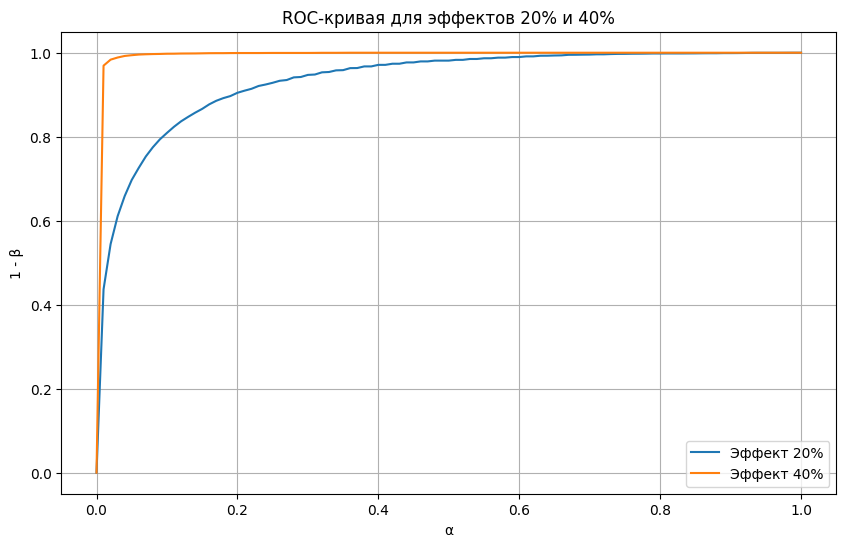

In [ ]:
alpha_range = np.arange(0, 1.01, 0.01)
n_sim = 10**4
sample_size = 1000

pvals_20 = []
pvals_40 = []

for _ in range(n_sim):
    # Эффект 20%
    x_control, x_treatment_20 = gen_sample(sample_size, 0.2, 0.2)
    _, pval_20 = asy_mean_test(x_control, x_treatment_20, alternative='larger')
    pvals_20.append(pval_20)

    # Эффект 40%
    x_control, x_treatment_40 = gen_sample(sample_size, 0.4, 0.2)
    _, pval_40 = asy_mean_test(x_control, x_treatment_40, alternative='larger')
    pvals_40.append(pval_40)

beta_20 = [np.mean(np.array(pvals_20) >= a) for a in alpha_range]
beta_40 = [np.mean(np.array(pvals_40) >= a) for a in alpha_range]

plt.figure(figsize=(10,6))
plt.plot(alpha_range, 1 - np.array(beta_20), label='Эффект 20%')
plt.plot(alpha_range, 1 - np.array(beta_40), label='Эффект 40%')
plt.xlabel('α')
plt.ylabel('1 - β')
plt.title('ROC-кривая для эффектов 20% и 40%')
plt.legend()
plt.grid()
plt.show()

Нарисуйте точно такую же кривую для ситуации, когда была верна нулевая гипотеза.

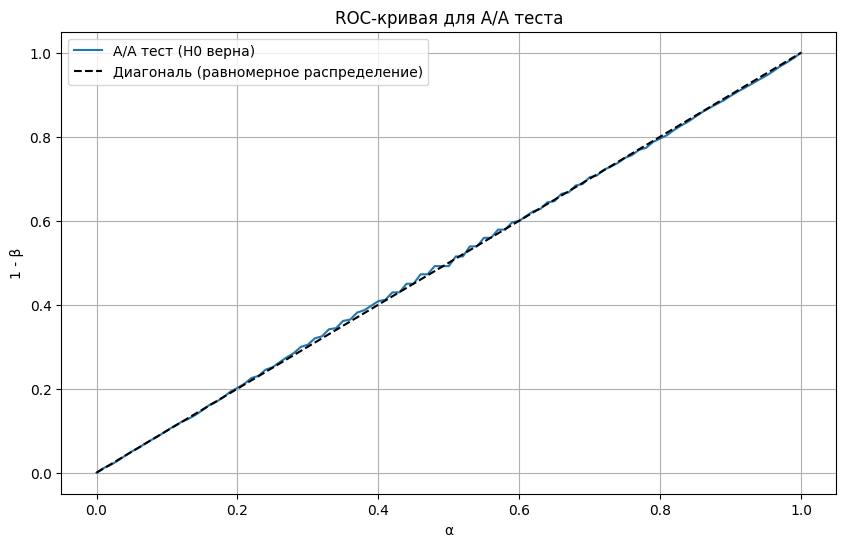

In [ ]:
pvals_AA = []

for _ in range(n_sim):
    x_control, _ = gen_sample(sample_size, 0, 0.2)
    x_control_again, _ = gen_sample(sample_size, 0, 0.2)
    _, pval_AA = asy_mean_test(x_control, x_control_again, alternative='larger')
    pvals_AA.append(pval_AA)

beta_AA = [np.mean(np.array(pvals_AA) >= a) for a in alpha_range]

plt.figure(figsize=(10,6))
plt.plot(alpha_range, 1 - np.array(beta_AA), label='A/A тест (H0 верна)')
plt.plot([0, 1], [0, 1], '--k', label='Диагональ (равномерное распределение)')
plt.xlabel('α')
plt.ylabel('1 - β')
plt.title('ROC-кривая для A/A теста')
plt.legend()
plt.grid()
plt.show()

Вместо осей $(\alpha, \beta)$ обычно такой график рисуют в осях $(\alpha, 1 - \beta)$. Давайте построим его и проинтерпретируем.

In [ ]:
def plot_pvalue_distribution(dict_pvalues):
    xseq = np.linspace(0, 1, 1000)

    for key, pvalues in dict_pvalues.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=key)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Распределение p-value/ROC-кривая', size=16)
    plt.xlabel('alpha', size=12)
    plt.ylabel('1 - beta', size=12)
    plt.legend(fontsize=12)
    plt.grid()

Заполните пропуски в коде ниже, чтобы для нашего АБ-теста отрисовались ROC-кривые.

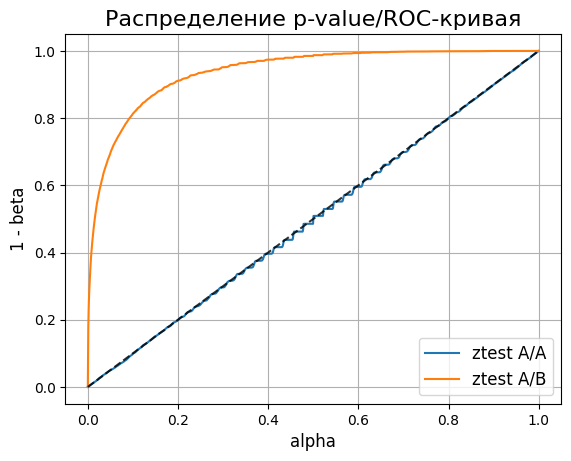

In [ ]:
n_sim = 10**4
sample_size = 1000

dict_pvalues = defaultdict(list)
for _ in range(n_sim):

    x_control, x_treatment = gen_sample(sample_size, 0.2, 0.2)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment, alternative='larger')

    # сгенерируем ещё одну тестовую выборку, чтобы убедиться, что в случае когда выборки совпали,
    # наш тест работает корректно и не находит разницу
    x_control_again, _ = gen_sample(sample_size, 0, 0.2)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again, alternative='larger')

    x_control_again, _ = gen_sample(1000, 0, 0.2)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again, alternative='larger')

    dict_pvalues['ztest A/A'].append(pval_aa)
    dict_pvalues['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(dict_pvalues)


Получившийся график можно проинтерпретировать двумя способами. Мы много-много раз проводим АБ-тест. В начале теста мы зафиксировали какую-то $\alpha$ и дальше проверяем кучу гипотез.

1. Линия `ztest A/A` это функция распределения pvalue при верности нулевой гипотезы. Оно было равномерным, мы двигаем $\alpha$ по оси $OX$ и оцениваем $\mathbb{P}(\text{pvalue} \le \alpha) = F(\alpha)$.  

По аналогии, линия `ztest A/B` это функция распределения pvalue при верности альтернативной гипотезы.

2. Линию `ztest A/B` можно проинтерпретировать как ROC-кривую. Если вы уже знаете про задачу классификации из машинного обучения, то это ровно оно. Полнота это $1 - \beta$, то есть то, сколько верных альтернативных гипотез мы найдём, если будем использовать наш АБ-тест, FPR это $\alpha$, то есть то, сколько верных нулевых гипотез мы заберём с собой в альтернативные. Эту величину мы определяем до старта эксперимента.

> Важно: если вы не поняли интерпретацию из пункта 2, просто забейте. Заботаете МО, поймёте. Интерпретацию из пункта 1 должны понять все. Если вы её не поняли, время напрячься и подумать ещё разок.

__Что для нас важно:__

- Чем выпуклее график, тем лучше мы находим эффект и процедура проверки гипотезы работае корректно;
- Чем больше у нас наблюдений тем выпуклее график;
- Чем сильнее в тестовой выборке подскакивает $p_t$ при изменениях, тем легче нам найти эффект и тем выпуклее график;
- Если $p_t$ подскочило на очень маленькую величину, нам сложнее найти это изменение, и график будет менее выпуклым;
- Чем меньше в выборках дисперсия, тем выпуклее график.

__е) [2 балла]__ При верности альтернативной гипотезы, постройте ROC-кривые из пункта выше для разного числа наблюдений в выборке: 10, 100, 1000, 10000 при любом фиксированном эффекте.

<ipython-input-3-57ac6e1dfc35>:10: RuntimeWarning: invalid value encountered in scalar divide
  z_obs = (mu_t - mu_c) / se


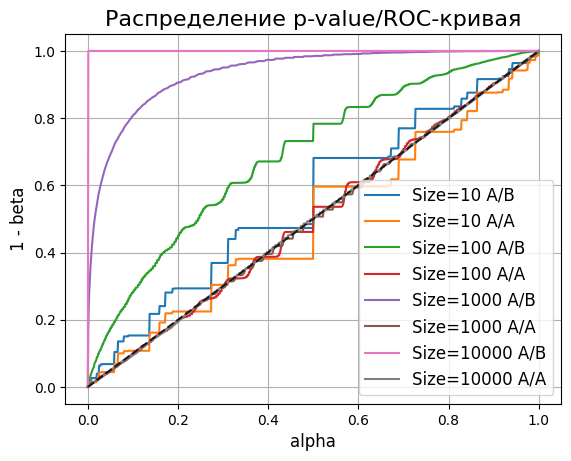

In [ ]:
sample_sizes = [10, 100, 1000, 10000]
dict_pvalues_sizes = {}

for n_obs in sample_sizes:
    pvals_ab = []
    pvals_aa = []
    for _ in range(n_sim):
        x_control, x_treatment = gen_sample(n_obs, 0.2, 0.2)
        _, p_ab = asy_mean_test(x_control, x_treatment, alternative='larger')

        x_control_again, _ = gen_sample(n_obs, 0, 0.2)
        _, p_aa = asy_mean_test(x_control, x_control_again, alternative='larger')
        pvals_ab.append(p_ab)
        pvals_aa.append(p_aa)
    dict_pvalues_sizes[f'Size={n_obs} A/B'] = pvals_ab
    dict_pvalues_sizes[f'Size={n_obs} A/A'] = pvals_aa

plot_pvalue_distribution(dict_pvalues_sizes)

__ё) [1 балл]__ Количество наблюдений, ошибка 1 и 2 рода, размер эффекта, который мы ищем и дисперсия в выборках связаны между собой. Для некоторых критериев проверки гипотез можно вывести формулы, которые их связывают.

В данном случае, формула для расчета числа наблюдений _для одной группы_ выглядит вот так:

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

В приложении Яндекс.Такси в конце поездки вылезают рандомные опросники. В одном из опросников задаётся вопрос «А вы пристёгивались, когда ехали?»

В России, в день, в Такси происходит 1 миллион заказов. Вопрос про ремни задаётся рандомным 10% пользователей, закончивших поездку. Пользователь не игнорирует опросник и отвечает на него да или нет с вероятностью 5% (цифры взяты из головы и не отражают реальную статистику).

Менеджер Екатерина хочет сделать так, чтобы когда пассажир садится в машину, Алиса просила его пристегнуться. Хочется замерить, какой эффект это даст на пристёгивания. Станут ли люди чаще пристёгиваться. Замерять мы это будем опросником. Сейчас 10% пользователей говорят, что пристегнулись.

Екатерина пришла к вам и между вами состоялся следующий диалог:

- Хочу АБ-тест с разбивкой 50 на 50.
- Какие ошибки 1 и 2 рода хочешь?
- Нулевые.
- Нам надо бесконечно наблюдений, готова столько ждать?
- Нет.
- На сколько мы хотим, чтобы выросла доля ответов да?
- Если подрастёт хотябы на процент, будет круто.
- То есть если меньше процента, такой эффект считаем неудачей и отсутствием изменения?
- Да.
- Давай я нарисую тебе табличку с разными ошибками, а внутри на пересечении напишу сколько дней надо ждать, чтобы найти такой минимальный эффект.
- Давай, по ней и примем решение.

Нарисуйте для Екатерины такую табличку. Не забудьте перевести общее количество наблюдений в дни.

In [ ]:
import pandas as pd

alphas = [0.01, 0.05, 0.1, 0.2]
betas = [0.1, 0.2, 0.3, 0.4, 0.5]
MDE = 0.01
p = 0.10
var = p * (1 - p)
daily_responses = 1e6 * 0.1  # 100000 ответов в день

data = {}
for beta in betas:
    row = {}
    for alpha in alphas:
        z_alpha = stats.norm.ppf(1 - alpha/2)
        z_beta = stats.norm.ppf(1 - beta)
        n_one = (0.18 * (z_alpha + z_beta)**2) / (MDE**2)
        total_samples = 2 * n_one
        days = total_samples / daily_responses
        row[f"α={alpha}"] = days
    data[f"β={beta}"] = row

df_days = pd.DataFrame(data).T
print("Таблица требуемых дней для обнаружения эффекта:")
df_days


Таблица требуемых дней для обнаружения эффекта:


,α=0.01,α=0.05,α=0.1,α=0.2
β=0.1,0.535658,0.378267,0.308299,0.236502
β=0.2,0.420443,0.282560,0.222572,0.162283
β=0.3,0.346011,0.222194,0.169404,0.117413
β=0.4,0.288153,0.176355,0.129714,0.084813
β=0.5,0.238856,0.138293,0.097400,0.059125


__ж) [1 балл]__ Попробуем сломать наш АБ-тест. Когда мы используем z-тест, мы размышляем в терминах центральной предельной теоремы. Тест будет работать, если выполнены предпосылки ЦПТ:

- Наблюдения независимо одинаково распределены
- В данных нет выборосов, дисперсия конечная
- Данных много

Давайте сломаем одно из условий и попробуем собрать выборку из [распределения Парето](https://ru.wikipedia.org/wiki/Распределение_Парето).

In [ ]:
def gen_sample(n_obs, effect, b=0.5):
    x_control = stats.pareto(b=b).rvs(n_obs)
    x_treatment = stats.pareto(b=b).rvs(n_obs)
    x_treatment = (1 + effect) * x_treatment
    return x_control, x_treatment

Отрисуйте ROC-кривые для $b=3$, $b=1$, $b=0.5$

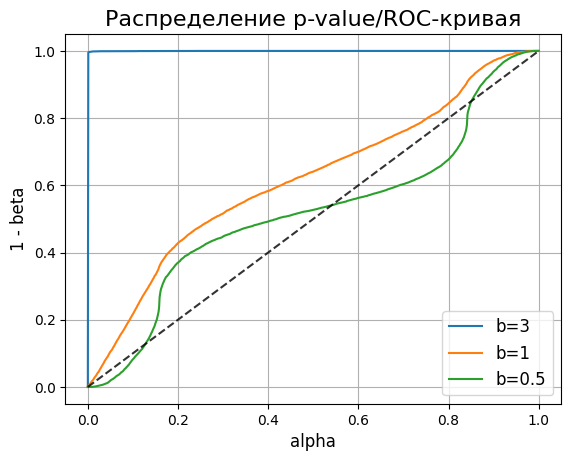

In [ ]:
n_sim = 10**4
sample_size = 1000
effect = 0.2
dict_pvalues_pareto = defaultdict(list)

b_values = [3, 1, 0.5]
for b in b_values:
    pvals = []
    for _ in range(n_sim):
        x_control, x_treatment = gen_sample(sample_size, effect, b=b)
        _, pval = asy_mean_test(x_control, x_treatment, alternative='larger')
        pvals.append(pval)
    dict_pvalues_pareto[f'b={b}'] = pvals

plot_pvalue_distribution(dict_pvalues_pareto)

Возьмите при каждом $b$ одну выборку, нарисуйте для неё гистограмму и посмотрите как обстоят дела с выбросами.

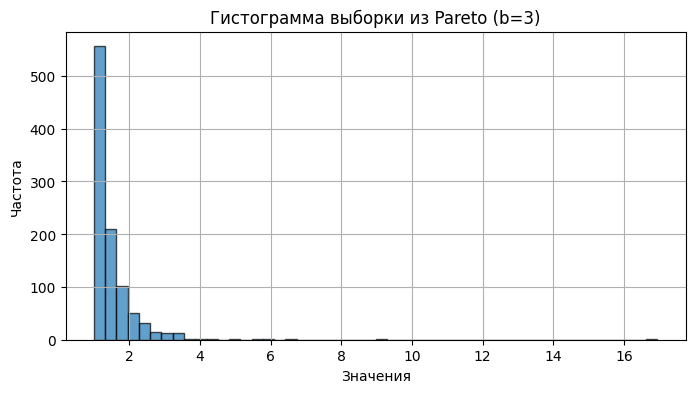

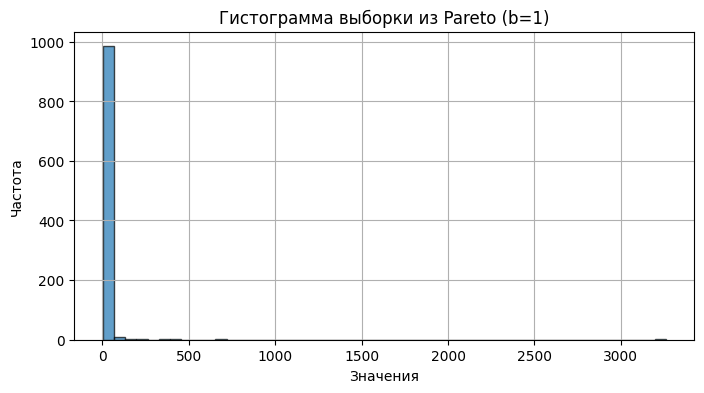

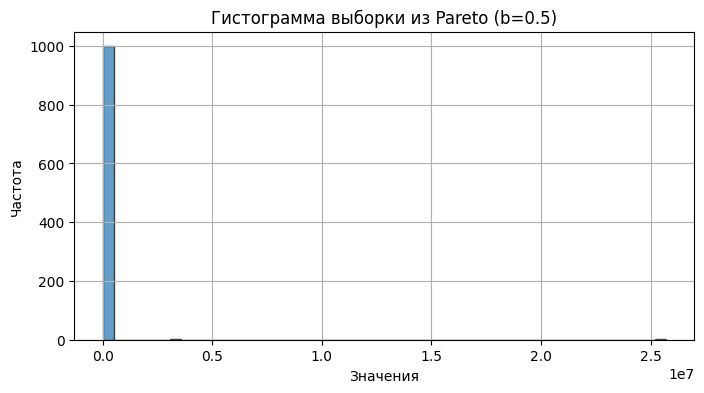

In [ ]:
for b in b_values:
    x_control, _ = gen_sample(sample_size, 0, b=b)
    plt.figure(figsize=(8,4))
    plt.hist(x_control, bins=50, edgecolor='k', alpha=0.7)
    plt.title(f'Гистограмма выборки из Pareto (b={b})')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

У распределения Парето не всегда существует дисперсия. Это ломает предпосылки ЦПТ и АБ-тест разваливается.

Возникает вполне резонный вопрос: а что делать в таких ситуациях? Есть несколько дорог.

- Во-первых, можно отвязаться от математического ожидания и поработать с медианой. Для неё тоже можно вывести асимптотическое распределение с помощью дельта-метода.
- Во-вторых, можно попробовать другие техники проверки гипотез. Например, бутстрап и непараметрические критерии.

Об этом мы и будем говорить на следующих парах.